In [1]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [ ]:
!pip install light-the-torch
!ltt install torch torchvision

In [ ]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import multiprocessing

# Set a few constants related to data loading.
NUM_WORKERS = min(multiprocessing.cpu_count(), 20)

In [3]:
# Device configuration
device = torch.device('cuda')

In [ ]:
# Define the dataset class
class LicensePlateDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super(LicensePlateDataset, self).__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, index):
        img, targets = super(LicensePlateDataset, self).__getitem__(index)
        if self.transform is not None:
            img = self.transform(img)

        # Extracting boxes and labels from targets
        boxes = [target['bbox'] for target in targets]
        labels = [target['category_id'] for target in targets]

        # Convert COCO bbox format to [x0, y0, x1, y1] format
        boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]

        target = {'boxes': torch.as_tensor(boxes, dtype=torch.float32),
                  'labels': torch.as_tensor(labels, dtype=torch.int64)}
        return img, target
# Define transforms
def get_transform():
    return T.Compose([T.ToTensor()])

# Paths to your dataset folders and annotation files
train_root = 'drive/MyDrive/FCOS/train'
train_annFile = 'drive/MyDrive/FCOS/train/_annotations.coco.json'

valid_root = 'drive/MyDrive/FCOS/valid'
valid_annFile = 'drive/MyDrive/FCOS/valid/_annotations.coco.json'

test_root = 'drive/MyDrive/FCOS/test'
test_annFile = 'drive/MyDrive/FCOS/test/_annotations.coco.json'

# Initialize datasets and dataloaders for each split
train_dataset = LicensePlateDataset(train_root, train_annFile, transform=get_transform())
valid_dataset = LicensePlateDataset(valid_root, valid_annFile, transform=get_transform())
test_dataset = LicensePlateDataset(test_root, test_annFile, transform=get_transform())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)), num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False,
                          collate_fn=lambda x: tuple(zip(*x)), num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                         collate_fn=lambda x: tuple(zip(*x)), num_workers=NUM_WORKERS)

# Load the pre-trained FCOS model
weights = FCOS_ResNet50_FPN_Weights.DEFAULT
model = fcos_resnet50_fpn(weights=weights)

# Training loop
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

# Validation function
def validate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            model(images)

# Test function
def test(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:  # Note the change here
            images = [img.to(device) for img in images]  # Move each image in the batch to the device
            outputs = model(images)


model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Do Transfer Learning
print("before epochs")
num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device)
    validate(model, valid_loader, device)
    print(f'Epoch {epoch}/{num_epochs} completed.')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
before epochs
Epoch 0/10 completed.
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.


In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(image, boxes, labels, scores, threshold=0.5):
    """
    Visualize predictions with bounding boxes and labels.

    Parameters:
    - image (Tensor): The image tensor.
    - boxes (Tensor): Bounding boxes.
    - labels (Tensor): Labels for each box.
    - scores (Tensor): Confidence scores for each prediction.
    - threshold (float): Score threshold for visualization.
    """
    # Convert tensor image to numpy
    image = image.cpu().numpy().transpose(1, 2, 0)

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x, y, x2, y2 = box
            rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f'{label}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))

    plt.show()
def test(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Visualize the first image in the batch
            img = images[0].cpu().data

            # Extract the bounding boxes, labels, and scores
            boxes = outputs[0]['boxes'].data.cpu()
            labels = outputs[0]['labels'].data.cpu()
            scores = outputs[0]['scores'].data.cpu()

            visualize_predictions(img, boxes, labels, scores)

In [6]:
# Testing the model
test(model, test_loader, device)

# Save the trained model
save_path = '/content/drive/My Drive/FCOS/fcos_license_plate_detector.pth'
torch.save(model.state_dict(), save_path)

print("Training, validation, and testing completed. Model saved.")

NameError: ignored

Downloading: "https://download.pytorch.org/models/fcos_resnet50_fpn_coco-99b0c9b7.pth" to /root/.cache/torch/hub/checkpoints/fcos_resnet50_fpn_coco-99b0c9b7.pth
100%|██████████| 124M/124M [00:00<00:00, 140MB/s]


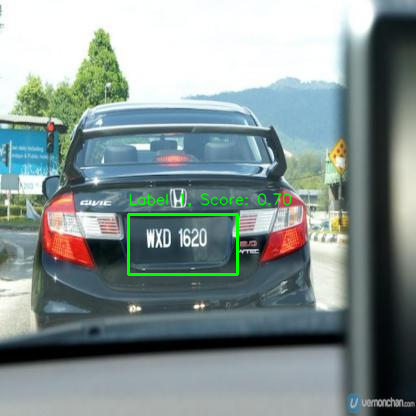

In [7]:
import cv2
from torchvision.transforms import functional as F
from google.colab.patches import cv2_imshow

# Load the trained model
def load_trained_model(model_path):
    weights = FCOS_ResNet50_FPN_Weights.DEFAULT
    model = fcos_resnet50_fpn(weights=weights)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model


model = load_trained_model('/content/drive/My Drive/FCOS/fcos_license_plate_detector.pth')

# Set the image path
image_path = '/content/drive/My Drive/FCOS/WXD1620_1.jpg'

# Load and process the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = F.to_tensor(image_rgb).unsqueeze(0)

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Draw bounding boxes and labels
for i in range(len(predictions[0]['boxes'])):
    box = predictions[0]['boxes'][i].cpu().numpy()
    score = predictions[0]['scores'][i].cpu().numpy()
    label = predictions[0]['labels'][i].cpu().numpy()

    # Set a threshold for scores (e.g., 0.5)
    if score > 0.5:
        x1, y1, x2, y2 = map(int, box)  # Convert coordinates to integers
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        image = cv2.putText(image, f'Label {label}, Score: {score:.2f}',
                            (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0, 255, 0), 1, cv2.LINE_AA)

# Display the resulting image
cv2_imshow(image)
cv2.waitKey(0)  # Wait for a key press to close the image window
cv2.destroyAllWindows()

In [12]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.8 MB/s eta 0:00:00


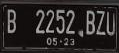

Detected text: B   2252,BZU


In [26]:
import numpy as np
import easyocr

# Create a reader instance
reader = easyocr.Reader(['en'])  # Assuming license plates are in English

def extract_text_from_plate(plate_image):
    results = reader.readtext(plate_image)
    threshold = 0.5  # Threshold for confidence score

    # Return empty string if no results
    if not results:
        return ""

    # Filter results based on confidence threshold
    filtered_results = [result[1] for result in results if result[2] >= threshold]

    # Fallback if no results meet the threshold
    if not filtered_results:
        # Option 1: Return text with the highest confidence
        highest_confidence_text = max(results, key=lambda x: x[2])[1]
        return highest_confidence_text
        # Option 2: Handle as an error or request manual review
        # return "Text below confidence threshold"

    return ' '.join(filtered_results)

def detect_license_plate(model, image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image_rgb).unsqueeze(0)

    with torch.no_grad():
        predictions = model(image_tensor)

    plates = []
    for i in range(len(predictions[0]['boxes'])):
        box = predictions[0]['boxes'][i].cpu().numpy()
        score = predictions[0]['scores'][i].cpu().numpy()

        if score > 0.5:  # Threshold
            x1, y1, x2, y2 = map(int, box)
            cropped_plate = image_rgb[y1:y2, x1:x2]
            plates.append(cropped_plate)

    return plates

# Preprocess the image for OCR
def preprocess_image_for_ocr(image):
    # Convert to grayscale
    if image is not None and len(image) > 0:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

        # Invert the image if it is predominantly white
        if np.mean(thresh) > 127:
            thresh = cv2.bitwise_not(thresh)
    else:
        return None

    resized_image = cv2.resize(thresh, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_AREA)
    return resized_image
# Example usage
model = load_trained_model('/content/drive/My Drive/FCOS/fcos_license_plate_detector.pth')
plates = detect_license_plate(model, '/content/drive/My Drive/FCOS/test/xpander12_jpg.rf.d6e4845364a9d46d79d16f729af177cb.jpg')

for plate_image in plates:
    if isinstance(plate_image, np.ndarray) and plate_image.size != 0:
        #preprocessed_image = preprocess_image_for_ocr(plate_image)
        cv2_imshow(plate_image)
        cv2.waitKey(0)  # Wait for key press to close the window
        cv2.destroyAllWindows()

        text = extract_text_from_plate(plate_image)
        print("Detected text:", text)
    else:
        print("No valid plate image found.")